<a href="https://colab.research.google.com/github/massone99/visione_artificiale_colab_notebooks/blob/main/CBIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CBIR system**
*   Obiettivo dell’esercitazione è la realizzazione di un sistema per la ricerca di immagini secondo il paradigma *query by example*.
*   Il sistema opera all’interno di un database di immagini rappresentanti oggetti in ceramica dipinti con disegni tipici della tradizione.
*   L’utente propone una query selezionando l’immagine di esempio desiderata e il sistema deve visualizzare le immagini del database più simile all’esempio dell’utente.
*   Prima di poter eseguire delle ricerche è necessario codificare le immagini del database attraverso opportune feature numeriche che ne descrivano le caratteristiche salienti (colore, forma, texture). Anche la query dell’utente dovrà essere codificata allo stesso modo.

<img src=https://biolab.csr.unibo.it/vr/esercitazioni/NotebookImages/EsCBIR/SistemaCBIR.png width="800">

# **Import delle librerie**
È necessario ora eseguire l'import delle librerie utilizzate durante l'esercitazione.
Per questa esercitazione è necessario inoltre utilizzare una versione specifica della libreria opencv perché si utilizzano feature (SIFT) che nelle versioni successive della libreria sono disponibili solo a pagamento.

In [1]:
!pip install  opencv-python
!pip install  opencv-contrib-python
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# **Utility functions**
Eseguire il codice seguente per definire alcune funzioni di utilità utilizzate nell'esercitazione:
*   `load_images` carica le immagini del database;
*   `show_images` visualizza un sottoinsieme delle immagini del database.


In [2]:
def load_images():
  db_img_list = [file for file in glob.glob(os.path.join('/content/CeramicheFaenza/','*.jpg'))]
  db_images = [cv2.imread(img) for img in db_img_list]
  return db_images

def show_images(images):
  rows = 5
  columns = 6
  plt.rcParams.update({'font.size': 20})
  _, axs = plt.subplots(rows, columns, squeeze=False, figsize=(30, 15))

  for i in range(rows*columns):
    r = i // columns
    c = i % columns
    axs[r, c].axis('off')
    axs[r, c].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

# **Dataset**

Il caso di studio per questa esercitazione è costituito da un dataset di immagini di ceramiche di Faenza che include immagini di piatti, ciotole, vasi, cofanetti caratterizzati da disegni e colori molto caratteristici.

In [ ]:
!wget http://bias.csr.unibo.it/VR/Esercitazioni/DBs/CeramicheFaenza.zip
!unzip /content/CeramicheFaenza.zip
!rm /content/CeramicheFaenza.zip

Visualizziamo alcune immagini del dataset...

In [ ]:
db_images = load_images()
show_images(db_images[:30])

... e carichiamo un'immagine da fornire al sistema come query. Per la selezione delle query utilizziamo le immagini nella cartella *Query* che vegono usate esclusivamente per l'interrogazione del sistema e non per il training.

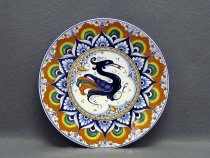

In [5]:
query = cv2.imread('/content/CeramicheFaenza/Query/0012_-_piatto_pavona_30_cm_0.jpg')
#query = cv2.imread('/content/CeramicheFaenza/Query/0020_-_piatto_garofano_31.5_0.jpg')
#query = cv2.imread('/content/CeramicheFaenza/Query/0365-porta-cioccolatini-ceramica_0.jpg')
#query = cv2.imread('/content/CeramicheFaenza/Query/0240-anfora-con-manici.jpg')
cv2_imshow(query)

# **Color**

Per ciò che riguarda le feature colore il descrittore sarà costituito dalla **concatenazione** degli **istogrammi colore** calcolati **separatamente** per i **3 canali RGB** dell'immagine.

Per il calcolo dell'istogramma si consiglia di utilizzare il medoto `cv2.calcHist` già visto nell'esercitazione introduttiva.
Un numero di bin pari a 20 può essere sufficiente, ma è bene analizzare l'impatto di questo parametro sulla qualità visiva del risultato prodotto.

Una volta definita la funzione `compute_color_features` questa può essere utilizzata per l'estrazione delle feature colore su tutte le immagini del dataset (di training).

In [7]:
def compute_color_features(image, num_bins=20):
    # Assicurati che l'immagine sia stata caricata correttamente
    if image is None:
        print("Impossibile leggere l'immagine:", image_path)
        return None

    # Separa l'immagine in canali RGB
    b, g, r = cv2.split(image)

    # Calcola gli istogrammi per ciascun canale
    hist_b = cv2.calcHist([b], [0], None, [num_bins], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [num_bins], [0, 256])
    hist_r = cv2.calcHist([r], [0], None, [num_bins], [0, 256])

    # Concatena gli istogrammi dei tre canali per creare il descrittore
    color_features = np.concatenate((hist_b, hist_g, hist_r))

    return color_features

db_color_features = [compute_color_features(img) for img in tqdm(db_images)]

  0%|          | 0/96 [00:00<?, ?it/s]

## Ricerca di similarità sulla base del colore
Data la query dell'utente, il sistema deve codificarla in modo analogo a quanto già fatto per le immagini del dataset, ovvero estraendo in questo caso il descrittore colore.

Sarà poi possibile confrontare il descrittore associato alla query con i singoli descrittori delle immagini del database.

Viene usata qui una misura di similarità tra descrittori basato sul concetto di intersezione tra istogrammi.

In [ ]:
def compute_color_feature_similarities(f1, f2):
  return #TODO

def compute_color_ranking(db_features, query_feature_vector):
  similarities =[compute_color_feature_similarities(db_feature_vector, query_feature_vector) for db_feature_vector in db_features]
  sorted_idx = np.array(similarities).argsort()[::-1]
  return sorted_idx

images_to_retrieve = 30
query_color_features = compute_color_features(query)
color_ranking = compute_color_ranking(db_color_features, query_color_features)
color_result = [db_images[i] for i in color_ranking]
cv2_imshow(query)
show_images(color_result[:images_to_retrieve])

# **Forma**
Per il calcolo del descrittore di forma si ricorrerà a un approccio che richiama il concetto di shape matrix.

In queste immagini lo sfondo è sufficientemente uniforme, mentre gli oggetti sono caratterizzati da una tessitura evidente. L'analisi del modulo del gradiente permette dunque di isolare l'oggetto dallo sfondo.

Il descrittore di forma si otterrà linearizzando l'immagine binaria `sm` ottenuta con i passaggi seguenti:

*   Calcolo del gradiente utilizzando il metodo Sobel. La funzione da richiamare è `cv2.Sobel`, usando come depth `cv2.CV_64F` e un kernel di dimensione 3. La funzione andrà richiamata due volte per il calcolo del gradiente in x (`xorder=1`, `yorder=0`) e in y (`xorder=0`, `yorder=1`)
*   Calcolo del modulo del gradiente
$g_{mod}(p)=\sqrt{g_x(p)^2+g_y(p)^2}$
*   Resize dell'immagine del modulo del gradiente a dimensione 30x20 con interpolazione bicubica (`cv2.resize(...)`)
*   Binarizzazione dell'immagine ridimensionata con soglia fissa 200 (`cv2.threshold(...)`)
*   Applicazione dell'operatore morfologico di chiusura (`cv2.morphologyEx(...)`). Si consiglia di utilizzare un elemento strutturante quadrato di dimensione 5x5.




<img src=https://biolab.csr.unibo.it/vr/esercitazioni/NotebookImages/EsCBIR/ShapeMatrix.png width="800">

In [ ]:
def compute_shape_features(img):
  #TODO
  return sm.flatten()

db_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in db_images]
db_shape_features = [compute_shape_features(img) for img in tqdm(db_gray_images)]

## Ricerca di similarità sulla base della forma

Anche in questo caso le immagini del database e la query vengono codificate usando il descrittore di forma sopra definito.

Per il calcolo della similarità tra descrittori si usa in questo caso un indicatore di tipo Intersection over Union (IoU):

<img src=https://biolab.csr.unibo.it/vr/esercitazioni/NotebookImages/EsCBIR/IoU.png width="400">

In [ ]:
def compute_shape_feature_similarities(f1, f2):
  return #TODO

def compute_shape_ranking(db_features, query_feature_vector):
  similarities =[compute_shape_feature_similarities(db_feature_vector, query_feature_vector) for db_feature_vector in db_features]
  sorted_idx = np.array(similarities).argsort()[::-1]
  return sorted_idx

query_shape_features = compute_shape_features(cv2.cvtColor(query, cv2.COLOR_BGR2GRAY))
shape_ranking = compute_shape_ranking(db_shape_features, query_shape_features)
shape_result = [db_images[i] for i in shape_ranking]
cv2_imshow(query)
show_images(shape_result[:images_to_retrieve])

# **Texture**
Il descrittore di tessitura viene calcolato utilizzando l'approccio Bag of (Visual) Words che vedremo più avanti a lezione.

L'idea di base è quella di codificare un'immagine attraverso un istogramma di occorrenze di alcuni pattern di base, rappresentati da punti salienti e caratteristici estratti dalle immagini di training. Il sistema necessita dunque di una fase di addestramento per l'estrazione di questo insieme di pattern di riferimento.

In [ ]:
def train_BOW(training_paths):
  dictionarySize = 100
  extractor = cv2.xfeatures2d.SIFT_create(edgeThreshold=10)
  matcher = cv2.BFMatcher(cv2.NORM_L2)

  BOW = cv2.BOWKMeansTrainer(dictionarySize)
  print('Keypoint extraction from training images')
  for p in tqdm(training_paths):
      image = cv2.imread(p, 0)
      kp, dsc= extractor.detectAndCompute(image, None)
      BOW.add(dsc)

  print('Creation of BOW dictionary')
  dictionary = BOW.cluster()
  bow_extractor = cv2.BOWImgDescriptorExtractor(extractor, matcher)
  bow_extractor.setVocabulary(dictionary)
  return bow_extractor

def compute_BOW_features(img, bow_extractor):
  extractor = cv2.xfeatures2d.SIFT_create(edgeThreshold=10)
  kp = extractor.detect(img)
  inp = bow_extractor.compute(img, kp)
  return inp

training_img_list = [file for file in glob.glob(os.path.join('/content/CeramicheFaenza','*.jpg'))]
bow_extractor = train_BOW(training_img_list)
print('BOW feature extraction')
db_BOW_features = [compute_BOW_features(img, bow_extractor) for img in tqdm(db_gray_images)]

## Ricerca di similarità sulla base della texture
Poiché il descrittore di tessitura utilizzato è un istogramma, si può usare l'intersezione come misura di similarità.

In [ ]:
def compute_bow_feature_similarities(f1, f2):
  return np.minimum(f1, f2).sum()

def compute_bow_ranking(db_features, query_feature_vector):
  similarities =[compute_bow_feature_similarities(db_feature_vector, query_feature_vector) for db_feature_vector in db_features]
  sorted_idx = np.array(similarities).argsort()[::-1]
  return sorted_idx

query_BOW_features = compute_BOW_features(query, bow_extractor)
bow_ranking = compute_bow_ranking(db_BOW_features, query_BOW_features)
bow_result = [db_images[i] for i in bow_ranking]
cv2_imshow(query)
show_images(bow_result[:images_to_retrieve])

# **Fusione dei risultati**
Il risultato finale si ottiene attraverso una fusione a livello di ranking. In particolare, i ranking prodotti con le singole feature vengono combinati con il metodo Borda Count.

<img src=https://biolab.csr.unibo.it/vr/esercitazioni/NotebookImages/EsCBIR/BordaCount.png width="800">

*   Ciascun tipo di feature produce un proprio ranking delle immagini del database, restituendo come risultato le K immagini più simili alla query (K=30).
*   Per il ranking finale, BC attribuisce all’immagine in posizione i "nella classifica" ($𝑖∈[0, 𝐾−1]$) un punteggio $𝑠_𝑖=𝐾−𝑖$.
*   In questa applicazione, viene attribuito un peso (nel range [0,1]) a ciascun tipo di feature, che si usa come fattore moltiplicativo per il punteggio $𝑠_𝑖$.


In [ ]:
def borda_count(rankings, weights):
  #TODO
  return tot_scores

tot_scores = borda_count([color_ranking, shape_ranking, bow_ranking], [0.2, 0.2, 0.6])
tot_ranking = np.array(tot_scores).argsort()[::-1]
result = [db_images[i] for i in tot_ranking]
cv2_imshow(query)
show_images(result[:images_to_retrieve])

# **Possibili miglioramenti**

## Colore
* Calcolare l'istogramma colore in altri spazi colore (YCbCr, HUV, etc.)
* Calcolare il descrittore colore come istogramma 3D anziché come concatenazione di 3 istogrammi mono-canale
* Calcolare l'istogramma solo nella regione contenente l'oggetto, senza includere lo sfondo

## Forma
* Provare tecniche alternative di segmentazione
* Implementare la shape matrix così come vista a lezione
